# Bank marketing dataset - Imbalance Example

In [178]:
# Importing Data Analysis Librarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
#from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from warnings import filterwarnings
filterwarnings('ignore')

In [179]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Bank Marketing veri seti  Portekizli bir bankacılık kurumunun doğrudan pazarlama kampanyaları ile ilgili müşterilerin pazarlama kampanyaları telefon görüşmelerine dayanan bir veri setidir. Hedef değişken, müşterilerin vadeli mevduata abone olup olmadığını göstermektedir. ("Evet veya Hayır)

Veri kümesi 41.188 ayrı kayıt ve 21 özellik içermektdir. Her kayıt, demografik, kredi, mevcut / önceki kampanya ve sosyal / ekonomik verilerin dahil edildiği bir banka müşterisine yapılan bir aramayı temsil etmektedir.

Buradaki iş hedefi, doğru müşterileri hedefleyerek pazarlama etkinliğini artırmaktır.

In [222]:
df= pd.read_csv(r'C:\Users\aslic\Downloads\bank-additional\bank-additional-full.csv', sep=';')
print("Bank marketing dataset shape is :",df.shape)
df.head()

Bank marketing dataset shape is : (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,no


In [230]:
len(df[df["y"]=="yes"])

4640

In [237]:
df["y"].value_counts()[1]

4640

In [242]:
def target_analysis(target, df):
    palette = {0: "darkred", 
             1: (0.6, 0.6, 0.6)}

    print("Yes : ", len(df[df[target]=="yes"]),
          "Yes Ratio :", "{:.2%}".format(len(df[df[target]=="yes"])/len(df)))

    plt.bar(['No', 'Yes'], df.y.value_counts().values, facecolor = 'brown', edgecolor='brown', linewidth=0.5, ls='dashed')
    sns.set(font_scale=1)
    plt.title('Target Status', fontsize=14)
    plt.xlabel('Status')
    plt.ylabel('Number of Customer')
    plt.show()

Yes :  4640 Yes Ratio : 11.27%


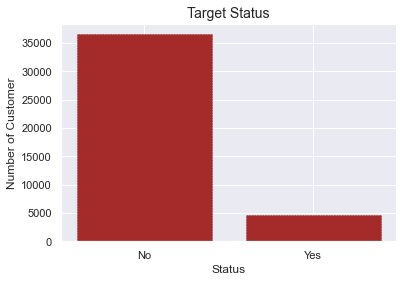

In [243]:
target_analysis("y", df)

Hedef değişkenimizin sınıfları arasında dengesizlik olduğunu görüyoruz. Kampanyaya evet diyen müşterilerin oranı %11
Sınıflandırma problemlerinde bunu hatırlamak önemlidir, çünkü makine öğrenimini kullanmadan bile 90 doğrulukla tahmin yapabiliriz. Ancak böyle bir durumda teklife evet diyen müşterileri tahmin etme şansımız çok zayıf olacaktır. Bu sorunu çözmeden bir sınıflandırma modeli oluşturursak model tamamen önyargılı olacaktır. 

Dengesizlik probleminin üstesinden gelebilmek için kullanılan farklı yöntemler mevcuttur. Bunlardan birkaç tanesini aşağıda incelmeye çalışacağım.

# 1- Resampling (Oversampling and Undersampling):

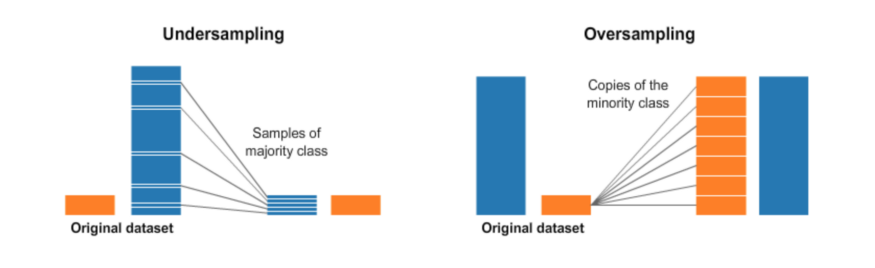

**Undersampling :** Hedef değişkene ait daha çok gözleme sahip sınıftan rastgele gözlem değerleri silinerek veri setindeki dengesizlik problemini çözmeyi hedefler.

In [182]:
# Veri setini shuffle ediyoruz.
shuffled_df = df.sample(frac=1,random_state=4)

# Kampanyaya evet yanıtı vermiş tüm müşteriler için ayrı bir data frame oluşturuyoruz.
yes_df = shuffled_df.loc[shuffled_df['y'] == "yes"]

# Veri setimizde hayır yanıtını verenler çoğunluk sınıfı oluşturuyor.
# Çoğunluk sınıfına ait verilerden evet diyenlerin belirlediğimiz oranda olacak rastgele gözlemleri seçiyoruz.
no_df = shuffled_df.loc[shuffled_df['y'] == "no"].sample(n=int(df.y.value_counts()[1]*1.5),random_state=42)

# Heriki datasetini birleştiriyoryz.
normalized_df = pd.concat([yes_df, no_df])


#### Sonuçları kontrol edelim. 

no    0.600
yes   0.400
Name: y, dtype: float64
Yes :  4640 Yes Ratio : 40.00%


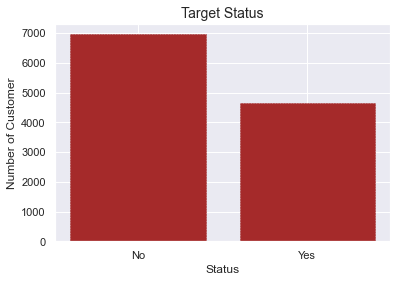

In [246]:
print((normalized_df.y.value_counts()/normalized_df.y.count()))
target_analysis( "y",normalized_df)

**Oversampling :** Bu yöntem Undersampling yöntemine göre biraz daha karmaşıktır Oversampling ile kampanya evet diyen müşterilere ait gözlemlerden rastgele oluşturulan bir örnek ile veriyi yapay bir şekilde çoğaltmaya çalışırız.

### SMOTE

Tipik bir sınıflandırma problemi için bir veri setini aşırı örneklemek için kullanılan birkaç yöntem vardır. En yaygın teknik **SMOTE** (`Synthetic Minority Over-sampling Technique`) olarak adlandırılır. Basit bir ifadeyle, azınlık sınıfı veri noktalarının özellik uzayına bakar ve en yakın komşularını dikkate alır.

In [184]:
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE

# Hedef değişikenimizde kampanyaya evet diyenlere ait "yes" sınıfını yeniden düzenliyoruz.
sm = SMOTE(sampling_strategy='minority', random_state=7,k_neighbors=5)

# Verileri oluşturmak için modeli fit ediyoruz. (Uygulama yapabilmek için sadece numrik değerleri aldım.)
oversampled_trainX, oversampled_trainY = sm.fit_resample(df[list(df.select_dtypes(exclude='object').columns)], df['y'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)



yes   0.500
no    0.500
Name: y, dtype: float64
Yes :  36548 Yes Ratio : 50.00%


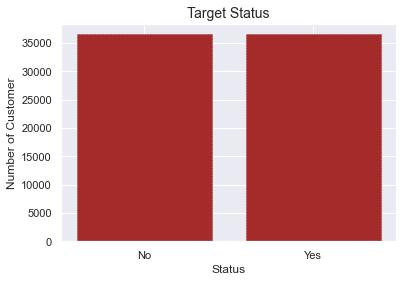

In [247]:
print((oversampled_train.y.value_counts()/oversampled_train.y.count()))
target_analysis( "y",oversampled_train)

# Aşağıda veri setini hızlıca işleyerek ile LGBM Modeli ile undersampling öncesi ve sonrasına ait model çıktılarını değerlendirdim.

Çalışmaya ait detayları model değerlendirmesinden sonraki kısımda bulabilirsiniz.

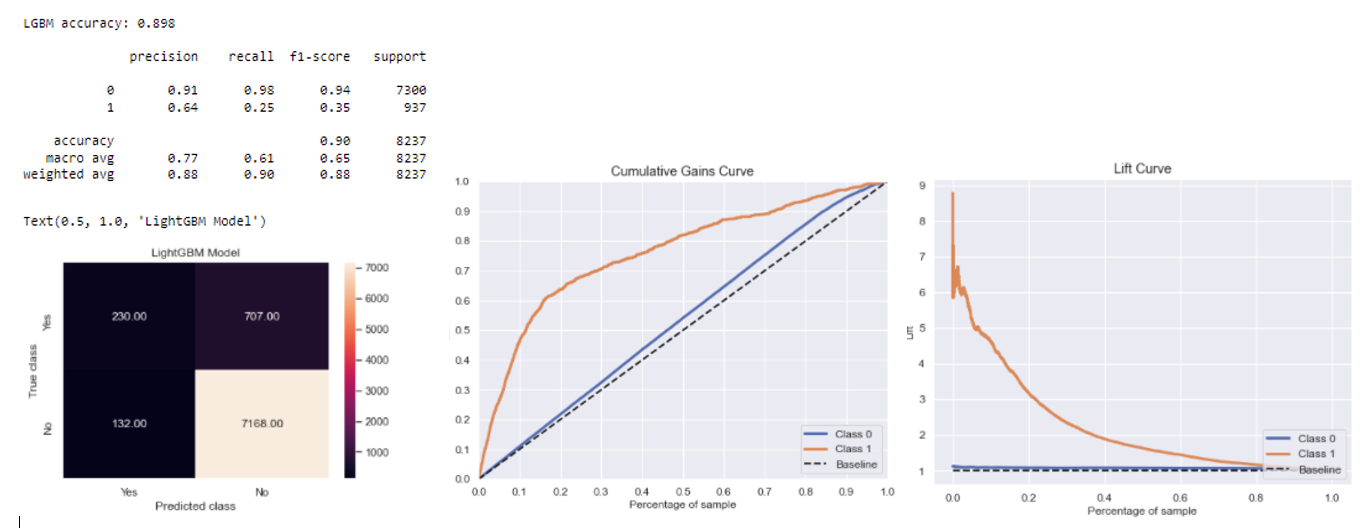

Yukarıda samling işlemleri öncesi LightGBM validationsonuçlarını görüyoruz. Recall değeri %25 olmasına rağmen modelin lifti oldukça iyi sonuç verdi.

Hedef değişkenimizin sınıfları şöyleydi : Evet diyenler %11, Hayır diyenler %89. Herhangi bir model kurmadan bulunulacak bir tahminin bu dağılıma uygun olacağını varsayabiliriz.
Model ilk %10'luk dilimde kampanyaya evet diyenlerin %50'sini yakalıyor. Dolayısıyla model kurmadığımız duruma göre 5 kat iyi bir iş çıkarmışız. 

Lif model sonuçlarını değerlendirmede oldukça kullanışlı bir metriktir. Model üretebileceği en iyi sonuçları üretse dahi eğer bir kampanya için hedef kitleyi tahmin ediyorsak sonuçları iş ihtiyaçları ve imkanları açısından da değerlendirmeliyiz. Örneğin kampanya sonuçlarına göre arama yapacak sınırlı sayıda arama yapabilecek büyüklükte olabilir ya da zaman kısıtı nedeniyle bir sınır olabilir. Örnekler çoğaltılabilir tabii ki. 

Bu durumda modelin ürettiği probabalitiy değerlerini azalan bir şekilde sıralayarak verinin yüzdelik dilimlerine göre en iyi tahminlerine odaklanabiliriz.

Veri setimizdeki imbalance probleme Random Undersampling ve Oversampling Smote tekniklerinin modelimize olan katkısına bakalım:



## Random Undersampling

Aşağıdaki Random Undersampling sonrası model'in validation sonuçlarını görüyoruz. İlk oluşturduğumuz modele göre recall değerinin %64 saviyesine çıktığını görüyoruz. Veri setinde evet diyenleri yakalamada tahmin gücümüz artmış. Model ilk modele göre veri setinde daha çok gözlemi "Evet" olarak tahminlemiş. Ancak bu tahminlerin %35'i isabetli olabilmiş. Dolayısıyla tahmin keskinliğimiz azalmış.

Modelin lift sonuçlarına baktığımızda ise ilk modelin sonuçları daha iyi diyebiliriz.

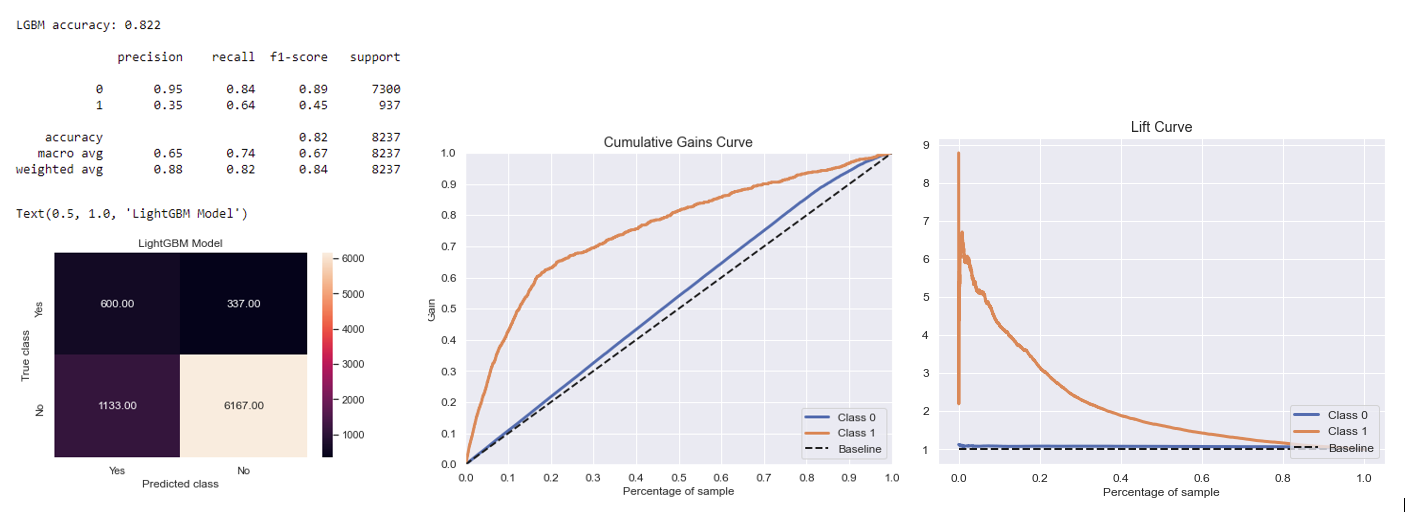


## Oversampling - Smote 

Smote Oversampling sonrası modelde ise daha dengeli bir recall ve presicion sonuçları görüyoruz. Modelin lifti açısından ilk %10'luk dilimde random undersampling ile benzer performansa sahip.


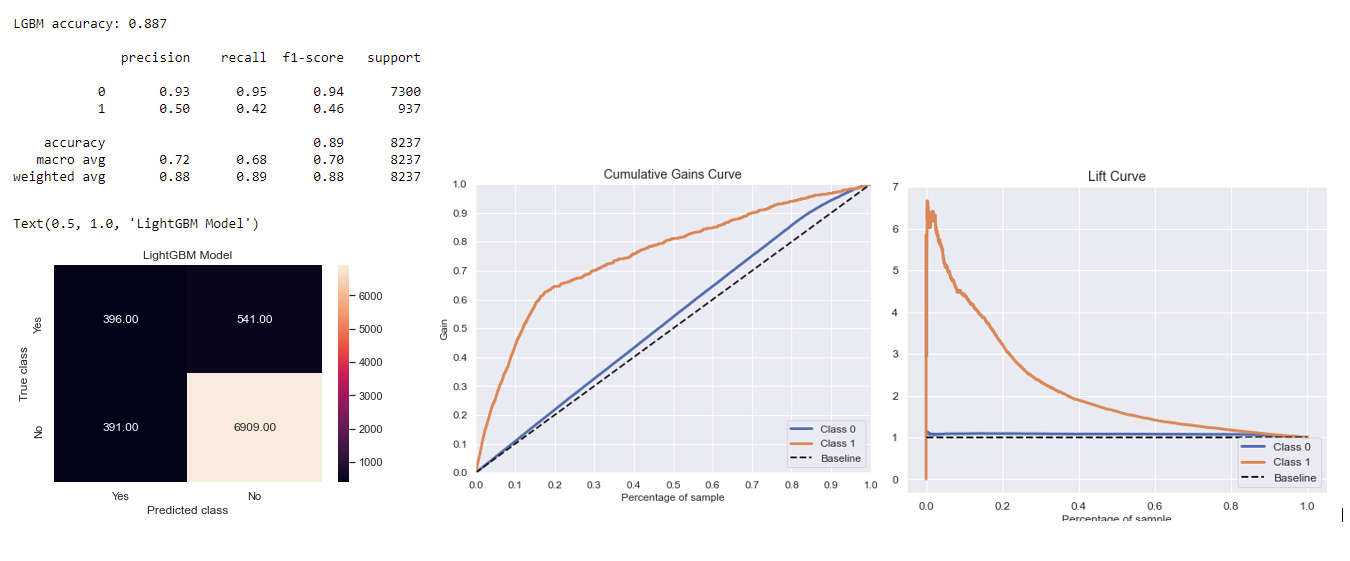

# Bank Additional

In [9]:
df= pd.read_csv(r'C:\Users\aslic\Downloads\bank-additional\bank-additional-full.csv', sep=';')

In [249]:
from Functions import*

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [12]:
cat, num = columns_dtypes(df)

# Missing Values

In [13]:
missing_values_table(df)

Veri setinde 21 değişken mevcut. 0 adet değişken eksik veriye sahip


,Total,Percent


# Zero Values

In [14]:
zero_values(df,num)[:10]

,cols,counts,per_zero
4,previous,35563,0.863
3,pdays,15,0.000
1,duration,4,0.000
0,age,0,0.000
2,campaign,0,0.000
5,emp.var.rate,0,0.000
6,cons.price.idx,0,0.000
7,cons.conf.idx,0,0.000
8,euribor3m,0,0.000
9,nr.employed,0,0.000


# Categorical Variables

# Number of Unique Values

In [15]:
nunique(df, cat)

job            12
month          10
education       8
day_of_week     5
marital         4
poutcome        3
loan            3
housing         3
default         3
y               2
contact         2
dtype: int64

In [16]:
col_names = df.select_dtypes(include='object').columns
for c in col_names:
    x = df[c].unique()
    print(color.BOLD+color.RED+c,"has",len(df[c].unique()),"unique element"+color.END)
    print(x,"\n")

job has 12 unique element
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student'] 

marital has 4 unique element
['married' 'single' 'divorced' 'unknown'] 

education has 8 unique element
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate'] 

default has 3 unique element
['no' 'unknown' 'yes'] 

housing has 3 unique element
['no' 'yes' 'unknown'] 

loan has 3 unique element
['no' 'yes' 'unknown'] 

contact has 2 unique element
['telephone' 'cellular'] 

month has 10 unique element
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep'] 

day_of_week has 5 unique element
['mon' 'tue' 'wed' 'thu' 'fri'] 

poutcome has 3 unique element
['nonexistent' 'failure' 'success'] 

y has 2 unique element
['no' 'yes'] 



In [17]:
num_data = df.shape[0]
for c in col_names:
    num_non = df[c].isin(["unknown"]).sum()
    if num_non > 0:
        x=len(df[(df[c]=="unknown") & (df.y=="yes")])/len(df[df.y=='yes'])
        print (c)
        print ("ratio of client whose", c,"status is unknown to among all new term campaign participants: {}%".format(round(x*100,2)))
        print ("unknown :", num_non)
        print ("ratio of unknown to among all", c,  "{0:.2f}%".format(float(num_non) / num_data * 100), '\n')   

job
ratio of client whose job status is unknown to among all new term campaign participants: 0.8%
unknown : 330
ratio of unknown to among all job 0.80% 

marital
ratio of client whose marital status is unknown to among all new term campaign participants: 0.26%
unknown : 80
ratio of unknown to among all marital 0.19% 

education
ratio of client whose education status is unknown to among all new term campaign participants: 5.41%
unknown : 1731
ratio of unknown to among all education 4.20% 

default
ratio of client whose default status is unknown to among all new term campaign participants: 9.55%
unknown : 8597
ratio of unknown to among all default 20.87% 

housing
ratio of client whose housing status is unknown to among all new term campaign participants: 2.31%
unknown : 990
ratio of unknown to among all housing 2.40% 

loan
ratio of client whose loan status is unknown to among all new term campaign participants: 2.31%
unknown : 990
ratio of unknown to among all loan 2.40% 



# Unknown Values

Yes :  781 Yes Ratio : 7.30%


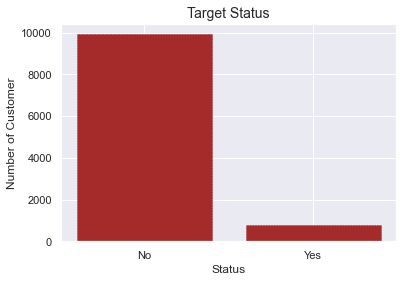

In [248]:
target_analysis( "y",df_unknown)

In [19]:
num_data = df.shape[0]
for c in col_names:
    num_non = df[c].isin(["unknown"]).sum()
    if num_non > 0:
        x=len(df[(df[c]=="unknown") & (df.y=="yes")])/len(df[df.y=='yes'])
        print('\n',c,"unknown:",'   \t',num_non,'\n',"unknown in y:",'   \t',"{}%".format(round(x*100,2)),'\n',"unknown in col :",'\t', "{0:.2f}%".format(float(num_non) / num_data * 100),)


 job unknown:    	 330 
 unknown in y:    	 0.8% 
 unknown in col : 	 0.80%

 marital unknown:    	 80 
 unknown in y:    	 0.26% 
 unknown in col : 	 0.19%

 education unknown:    	 1731 
 unknown in y:    	 5.41% 
 unknown in col : 	 4.20%

 default unknown:    	 8597 
 unknown in y:    	 9.55% 
 unknown in col : 	 20.87%

 housing unknown:    	 990 
 unknown in y:    	 2.31% 
 unknown in col : 	 2.40%

 loan unknown:    	 990 
 unknown in y:    	 2.31% 
 unknown in col : 	 2.40%


In [186]:
df.drop("default", inplace = True, axis = 1)

In [ ]:
cat, num = columns_dtypes(df)

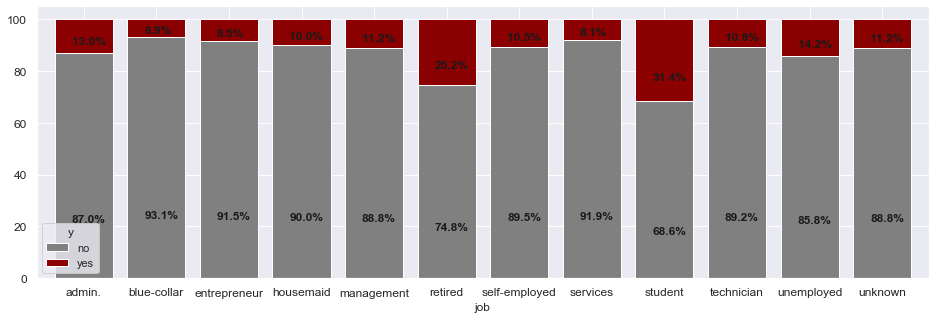

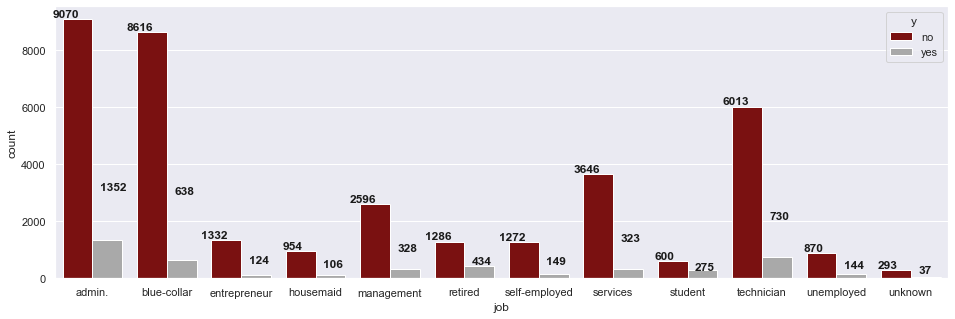

In [32]:
stacked(df,"job", "y")
bar_plot(df,"job","y","age")

In [ ]:
pro_course

In [39]:
df['education'].replace(['basic.4y'], 'basic',inplace=True, )
df['education'].replace(['basic.6y'], 'basic',inplace=True, )
df['education'].replace(['basic.9y'], 'basic',inplace=True, )
df['education'].replace(['high.school'], 'high_school',inplace=True)
df['education'].replace(['professional.course'], 'pro_course',inplace=True)
df['education'].replace(['university.degree'], 'university',inplace=True)
df['education'].replace(['illiterate'], 'basic',inplace=True)
df['education'].replace(['pro_course'], 'university',inplace=True)

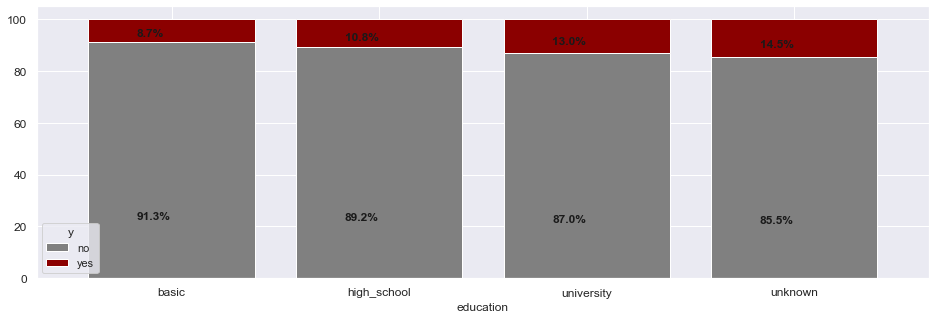

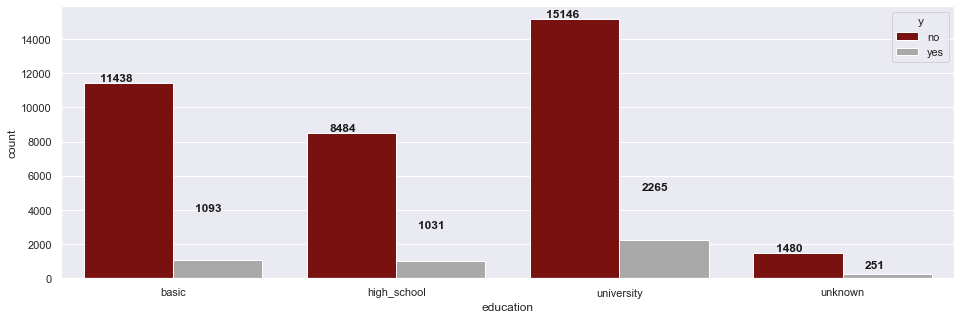

In [45]:
stacked(df,"education", "y")
bar_plot(df,"education","y","age")

In [46]:
pd.crosstab(df.job, df['education'])

education,basic,high_school,university,unknown
job,,,,
admin.,728,3329,6116,249
blue-collar,7375,878,547,454
entrepreneur,420,234,745,57
housemaid,646,174,198,42
management,351,298,2152,123
retired,820,276,526,98
self-employed,341,118,933,29
services,746,2682,391,150
student,138,357,213,167


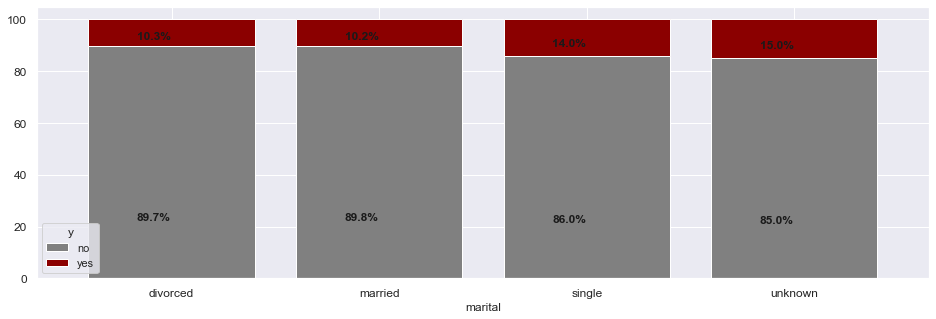

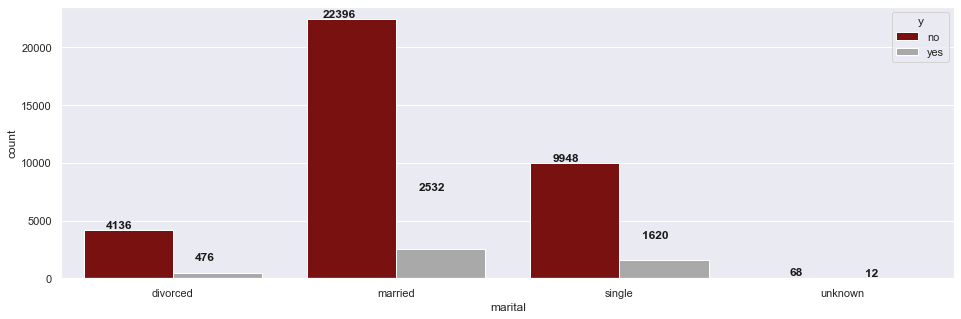

In [30]:
stacked(df,"marital", "y")
bar_plot(df,"marital","y","age")

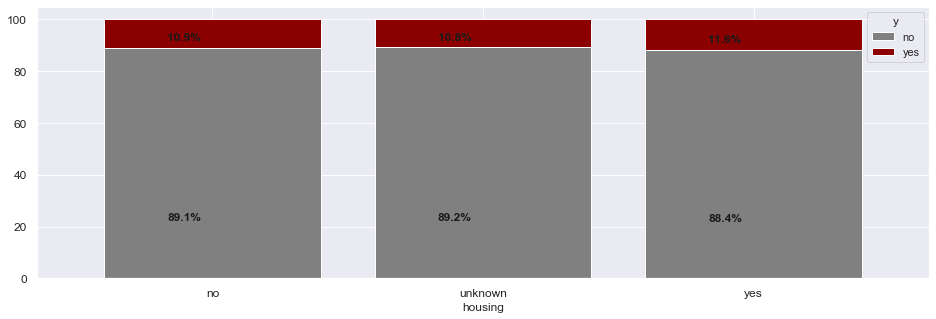

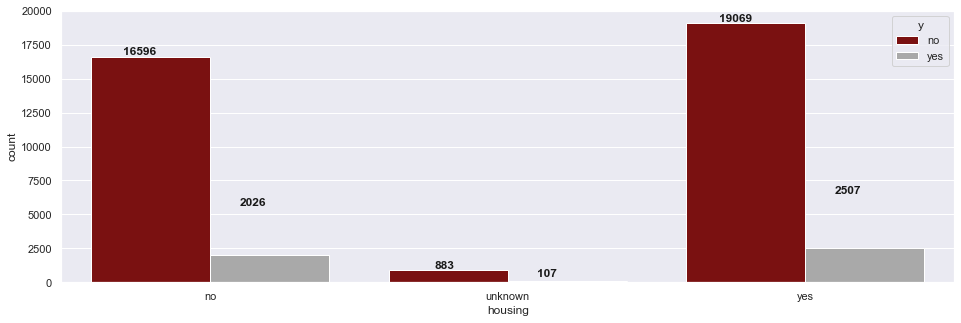

In [33]:
stacked(df,"housing", "y")
bar_plot(df,"housing","y","age")

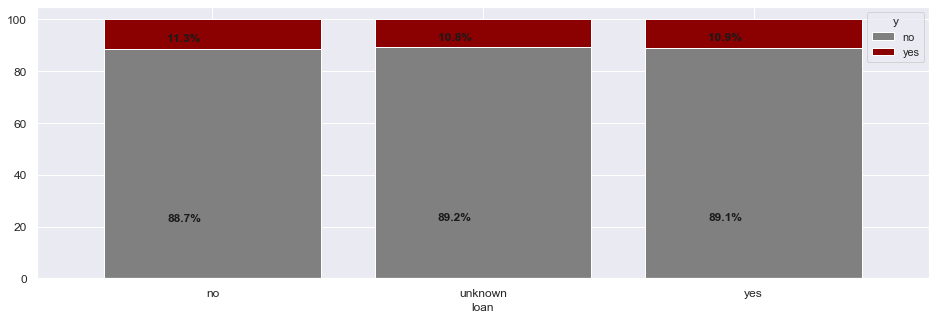

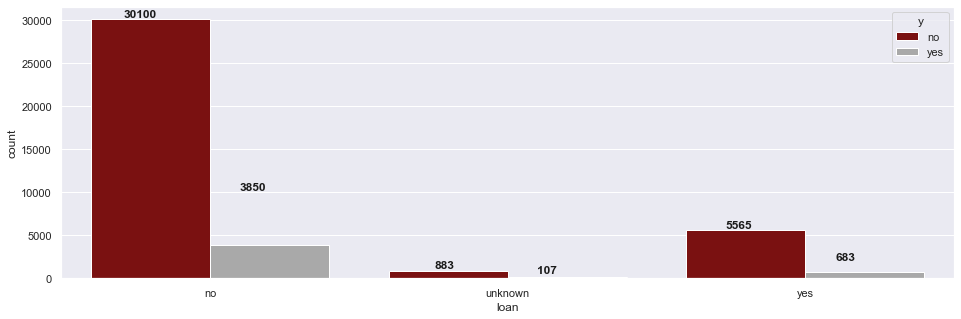

In [34]:
stacked(df,"loan", "y")
bar_plot(df,"loan","y","age")

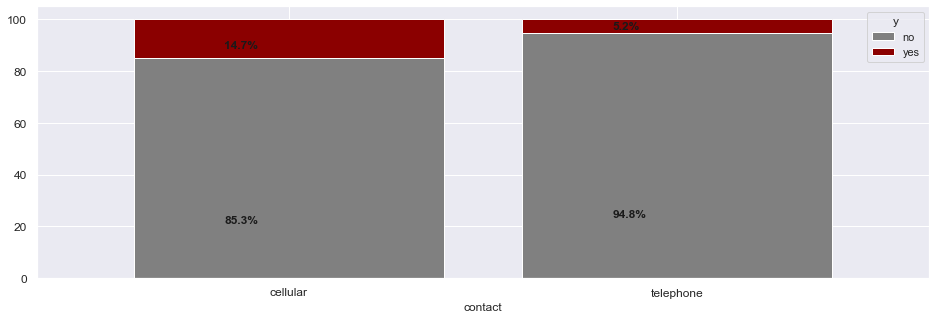

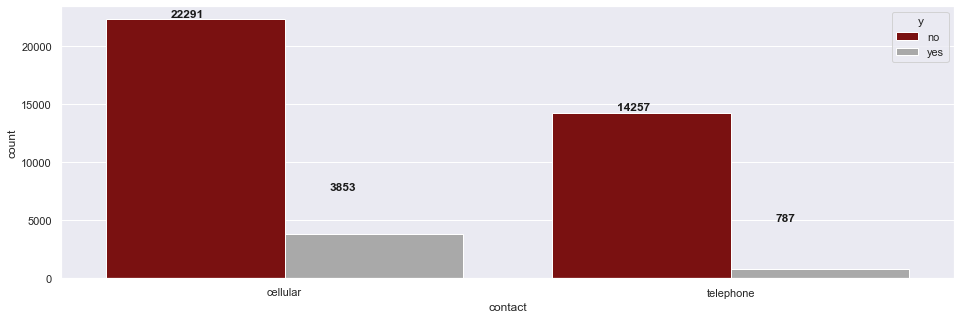

In [35]:
stacked(df,"contact", "y")
bar_plot(df,"contact","y","age")

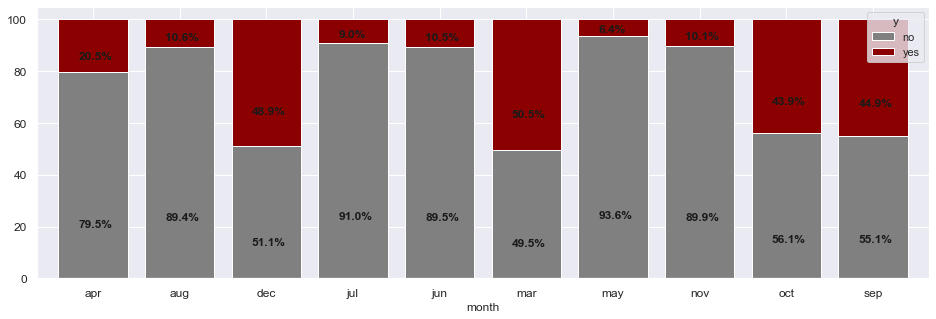

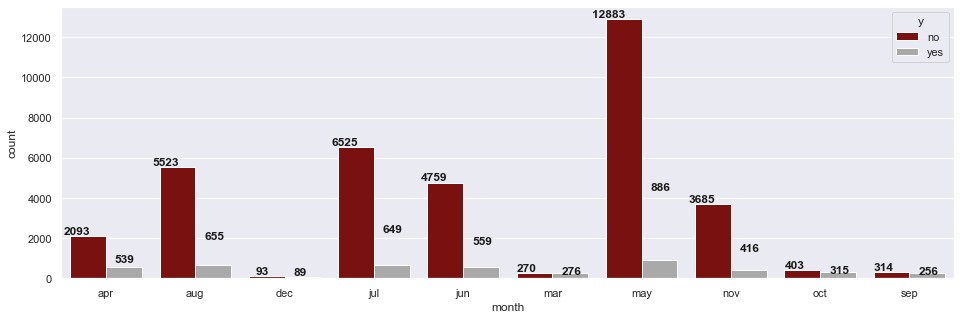

In [36]:
stacked(df,"month", "y")
bar_plot(df,"month","y","age")

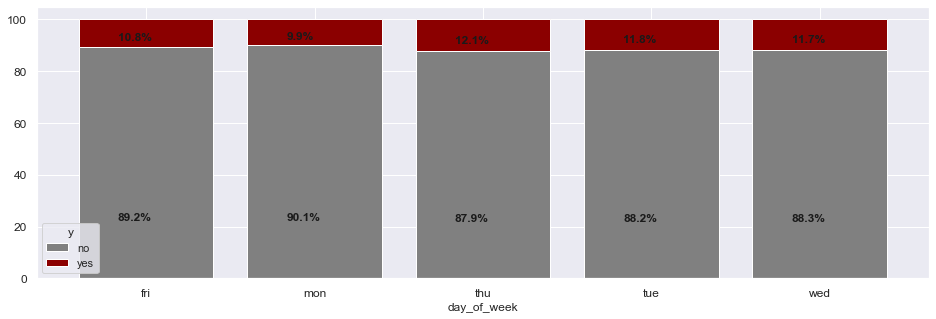

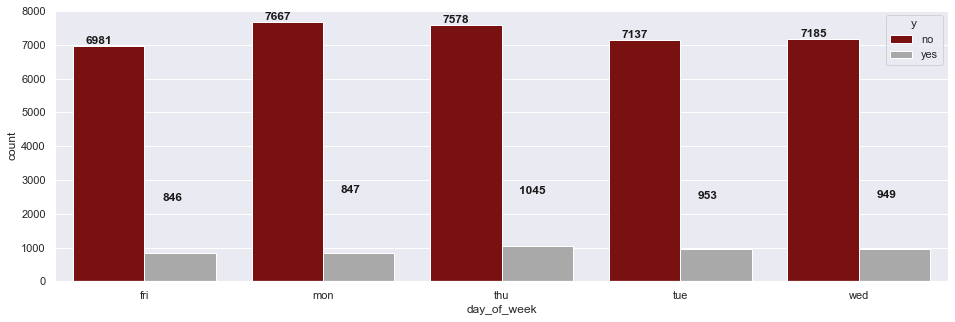

In [37]:
stacked(df,"day_of_week", "y")
bar_plot(df,"day_of_week","y","age")

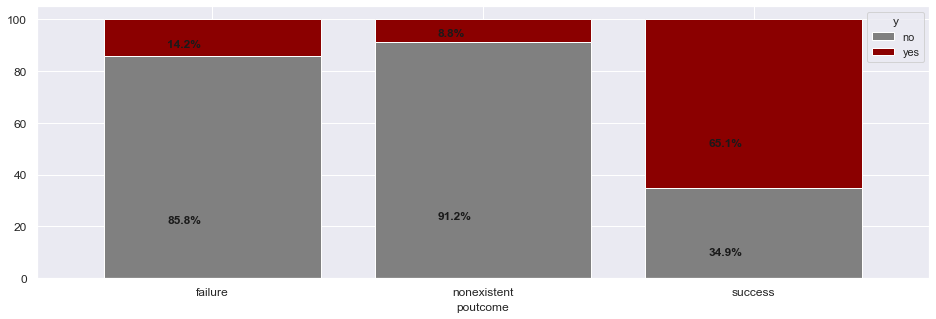

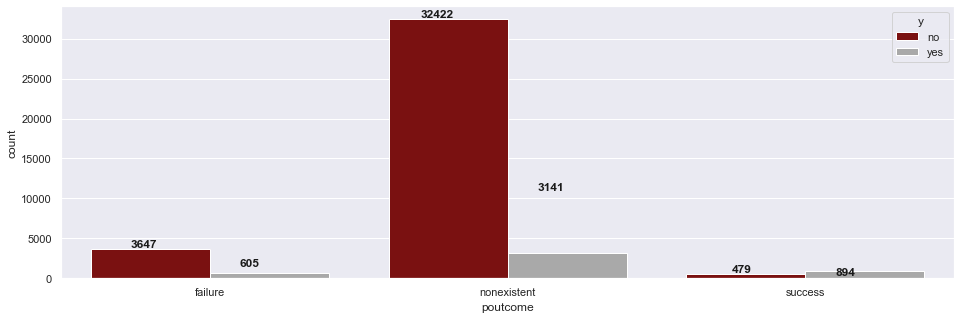

In [38]:
stacked(df,"poutcome", "y")
bar_plot(df,"poutcome","y","age")

In [187]:
df.drop(["month", "day_of_week", "contact", "job"], inplace = True, axis = 1)

## NUMERICAL VARIABLES

In [188]:
cat, num = columns_dtypes(df)

In [49]:
nunique(df, num)

duration          1544
euribor3m          316
age                 78
campaign            42
pdays               27
cons.conf.idx       26
cons.price.idx      26
nr.employed         11
emp.var.rate        10
previous             8
dtype: int64

###  duration değişkenini veri setinden düşüyorum. Bu değişken target değişkenin sonucuyla doğrudan ilişkili olmakla birlikte müşteriye teklifin sunulduğu anda olulabilecek bir değişken.

In [189]:
df.drop("duration", inplace = True, axis =1)

In [190]:
cat, num = columns_dtypes(df)

In [72]:
df[num].describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.5%,max
age,41188.000,40.024,10.421,17.000,23.000,26.000,28.000,32.000,38.000,47.000,55.000,58.000,71.000,77.000,98.000
campaign,41188.000,2.568,2.770,1.000,1.000,1.000,1.000,1.000,2.000,3.000,5.000,7.000,14.000,19.000,56.000
pdays,41188.000,962.475,186.911,0.000,3.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000,999.000
previous,41188.000,0.173,0.495,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,2.000,3.000,7.000
emp.var.rate,41188.000,0.082,1.571,-3.400,-3.400,-2.900,-1.800,-1.800,1.100,1.400,1.400,1.400,1.400,1.400,1.400
cons.price.idx,41188.000,93.576,0.579,92.201,92.201,92.713,92.893,93.075,93.749,93.994,94.465,94.465,94.465,94.601,94.767
cons.conf.idx,41188.000,-40.503,4.628,-50.800,-49.500,-47.100,-46.200,-42.700,-41.800,-36.400,-36.100,-33.600,-26.900,-26.900,-26.900
euribor3m,41188.000,3.621,1.734,0.634,0.658,0.797,1.046,1.344,4.857,4.961,4.964,4.966,4.968,4.968,5.045
nr.employed,41188.000,5167.036,72.252,4963.600,4963.600,5017.500,5076.200,5099.100,5191.000,5228.100,5228.100,5228.100,5228.100,5228.100,5228.100


In [75]:
has_outliers(df, num)

campaign : 18
pdays : 1515
previous : 6


In [191]:
outliers_update_up=  (df,['age', 'campaign'])

In [192]:
df['pdays_missing'] =0
df['pdays_missing'][df['pdays']<5] = "1-4"
df['pdays_missing'][(df['pdays']>=5)&(df['pdays']<=15)]= "5-15"
df['pdays_missing'][(df['pdays']>15) & (df['pdays']<999)] = "15+"
df['pdays_missing'][df['pdays']==999] = "999"
df = df.drop('pdays', axis=1);
df['pdays_missing']=df['pdays_missing'].astype('object')

In [193]:
df.pdays_missing.unique()

array(['999', '5-15', '1-4', '15+'], dtype=object)

In [194]:
x=df.pivot_table(index=["pdays_missing"],columns=["y"],values="age",aggfunc="count")
x

y,no,yes
pdays_missing,,
1-4,243,416
15+,18,20
5-15,287,531
999,36000,3673


In [196]:
cat, num = columns_dtypes(df)

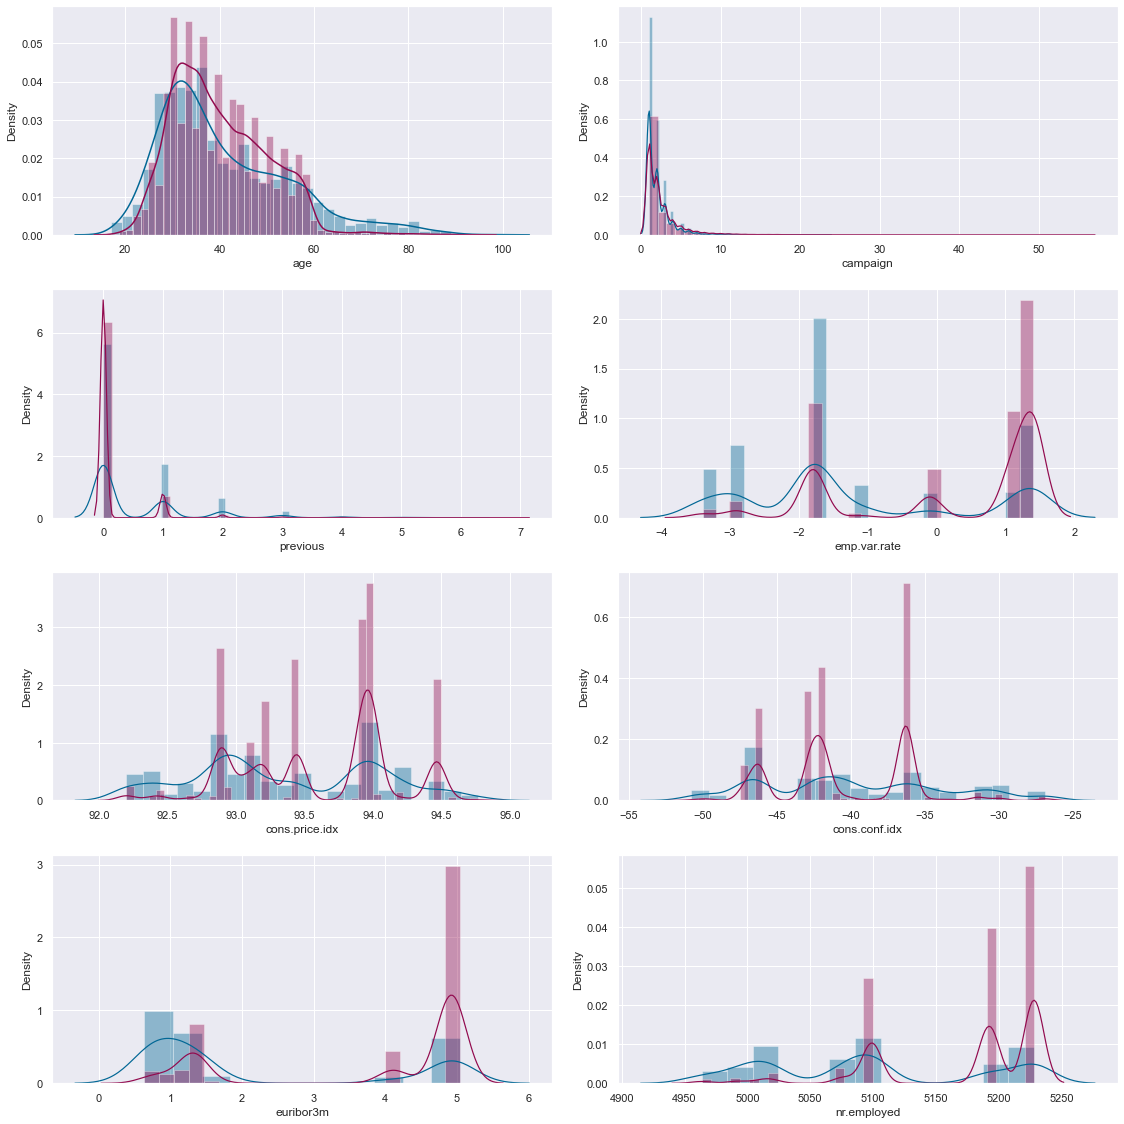

In [82]:
distplot(df, "y",num,4,2)

In [197]:
from sklearn.preprocessing import RobustScaler

In [198]:
std =['age', 'campaign',
       'cons.conf.idx', 'euribor3m',]


In [199]:
for col in std:   
    transformer = RobustScaler().fit(df[[col]])
    df[col] = transformer.transform(df[[col]])

# CORRELATIONS

In [200]:
UP_70 = df.corr().unstack().sort_values(ascending = False).drop_duplicates() >= 0.70
df.corr().unstack().sort_values(ascending = False).drop_duplicates()

nr.employed     nr.employed       1.000
euribor3m       emp.var.rate      0.972
                nr.employed       0.945
nr.employed     emp.var.rate      0.907
emp.var.rate    cons.price.idx    0.775
cons.price.idx  euribor3m         0.688
nr.employed     cons.price.idx    0.522
cons.conf.idx   euribor3m         0.278
emp.var.rate    cons.conf.idx     0.196
campaign        emp.var.rate      0.151
                nr.employed       0.144
euribor3m       campaign          0.135
cons.conf.idx   age               0.129
cons.price.idx  campaign          0.128
cons.conf.idx   nr.employed       0.101
cons.price.idx  cons.conf.idx     0.059
previous        age               0.024
euribor3m       age               0.011
age             campaign          0.005
                cons.price.idx    0.001
                emp.var.rate     -0.000
cons.conf.idx   campaign         -0.014
nr.employed     age              -0.018
previous        cons.conf.idx    -0.051
                campaign         -0.079


In [201]:
df=df.drop('nr.employed', axis=1)
df=df.drop('emp.var.rate', axis=1) 

In [202]:
cat, num = columns_dtypes(df)

In [203]:
for col in df[cat.difference(["y"])]:
    df[col]= df[col].astype("category")

In [204]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
df["y"] = labelencoder_X.fit_transform(df["y"]) 

In [205]:
df.head()

,age,marital,education,housing,loan,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y,pdays_missing
0,1.200,married,basic.4y,no,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
1,1.267,married,high.school,no,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
2,-0.067,married,high.school,yes,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
3,0.133,married,basic.6y,no,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
4,1.200,married,high.school,no,yes,-0.500,0,nonexistent,93.994,0.857,0.000,0,999


In [99]:
cols = df.columns.difference(["y"])

In [125]:
# Resampling sonrası eğittiğimiz modelin target değişkenimizdeki orjinal dağılımına göre sonuçlarını görmek için,
# veri setimizi split ediyoruz. 

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold

folds = RepeatedKFold(n_splits= 5, n_repeats=10, random_state=1001)
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[cols], 
                                                            df['y'])):
    train_x, train_y = df[cols].iloc[train_idx], df['y'].iloc[train_idx]
    valid_x, valid_y = df[cols].iloc[valid_idx], df['y'].iloc[valid_idx]
    

LGBM accuracy: 0.898 

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7300
           1       0.64      0.25      0.35       937

    accuracy                           0.90      8237
   macro avg       0.77      0.61      0.65      8237
weighted avg       0.88      0.90      0.88      8237



Text(0.5, 1.0, 'LightGBM Model')

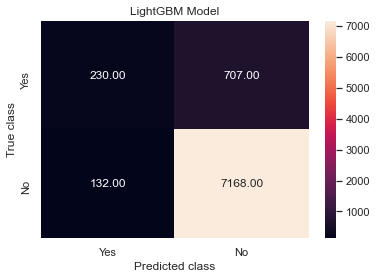

In [126]:
lgbm = LGBMClassifier()
lgbm.fit(train_x, train_y)
y_pred = lgbm.predict(valid_x)

print('LGBM accuracy: {:.3f}'.format(accuracy_score(valid_y, y_pred)), '\n')
print(classification_report(valid_y, y_pred))

cm = metrics.confusion_matrix( valid_y,y_pred, [1,0])
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LightGBM Model')

# FEATURE IMPORTANCE

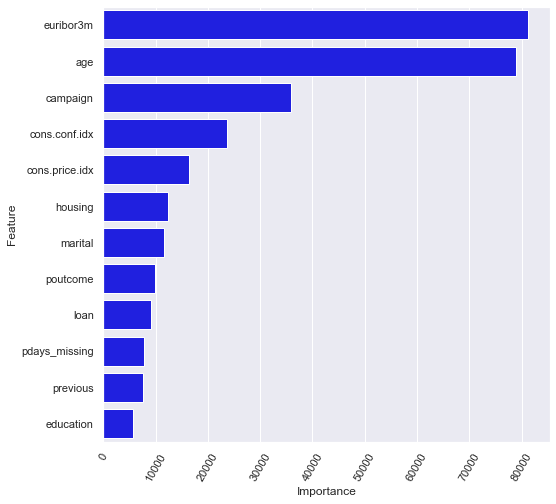

In [127]:
Importance = pd.DataFrame({'Importance': lgbm.feature_importances_ * 100,
                           'Feature': cols}).sort_values(by = "Importance", ascending = False)
fig=plt.figure(figsize=(8,8))
sns.barplot(x=Importance.Importance,y='Feature',data=Importance,color='blue')
plt.xticks(rotation=60)
plt.show()

# Fixing Imbalanced Data

# CUMULATIVE GAIN & LIFT CHART

In [128]:
import scikitplot as skplt
ypred_prob=lgbm.predict_proba(valid_x)

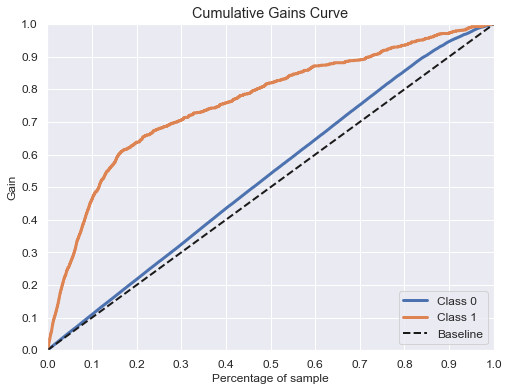

In [129]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(valid_y, ypred_prob,figsize=(8, 6))
valueX = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
plt.xticks(valueX)
plt.yticks(valueX)
plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

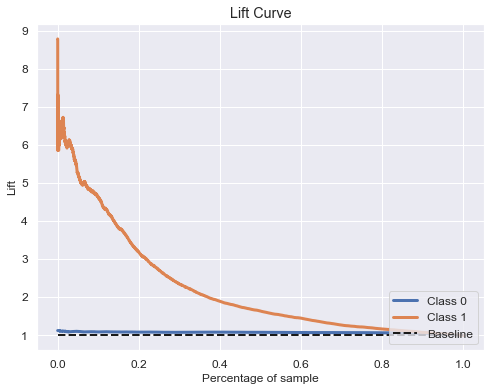

In [130]:
skplt.metrics.plot_lift_curve(valid_y, ypred_prob,figsize=(8, 6))

## Random Undersampling Example

In [167]:
train = pd.concat([train_y,train_x], axis=1)  

In [168]:
# Veri setini shuffle ediyoruz.
shuffled_df = train.sample(frac=1,random_state=4)

# Kampanyaya evet yanıtıvermiş tüm müşteriler için ayrı bir data frame oluşturuyoruz.
yes_df = shuffled_df.loc[shuffled_df['y'] == 1]

# Veri setimizde hayır yanıtını verenler çoğunluk sınıfı oluşturuyor.
# Çoğunluk sınıfına ait verilerden evet diyenlerin belirlediğimiz oranda olacak rastgele gözlemleri seçiyoruz.
no_df = shuffled_df.loc[shuffled_df['y'] == 0].sample(n=int(df.y.value_counts()[1]*0.81),random_state=42)

# Heriki datasetini birleştiriyoryz.
normalized_df = pd.concat([yes_df, no_df])


#### Sonuçları kontrol edelim. 

0   0.504
1   0.496
Name: y, dtype: float64


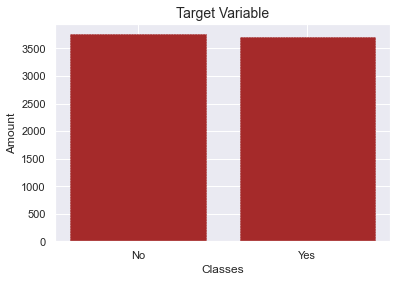

In [169]:
print((normalized_df.y.value_counts()/normalized_df.y.count()))

plt.bar(['No', 'Yes'], normalized_df.y.value_counts().values, facecolor = 'brown', edgecolor='brown', linewidth=0.5, ls='dashed')
sns.set(font_scale=1)
plt.title('Target Variable', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

In [170]:
normalized_df.head()

,y,age,campaign,cons.conf.idx,cons.price.idx,education_high_school,education_nan,education_university,education_unknown,euribor3m,housing_nan,housing_unknown,housing_yes,loan_nan,loan_unknown,loan_yes,marital_married,marital_nan,marital_single,marital_unknown,pdays_missing_15+,pdays_missing_5-15,pdays_missing_999,pdays_missing_nan,poutcome_nan,poutcome_nonexistent,poutcome_success,previous
39834,1,0.400,0.000,0.317,94.055,0,0,1,0,-1.145,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
40443,1,1.000,-0.500,0.556,94.027,0,0,1,0,-1.093,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
30360,1,1.333,-0.500,-0.841,93.075,0,0,0,0,-0.965,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
10049,1,1.133,-0.500,0.000,94.465,0,0,1,0,0.028,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
37122,1,1.533,-0.500,1.651,92.201,0,0,1,0,-1.098,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [171]:
# Train veri seti üzerinde undersamling uygulaması gerçekleştirdikten sonra model önce split uyguluyoruz.
X = normalized_df.drop("y",axis=1)
y = normalized_df["y"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123456)

LGBM accuracy: 0.754 

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       731
           1       0.82      0.66      0.73       762

    accuracy                           0.75      1493
   macro avg       0.76      0.76      0.75      1493
weighted avg       0.77      0.75      0.75      1493



Text(0.5, 1.0, 'LightGBM Model')

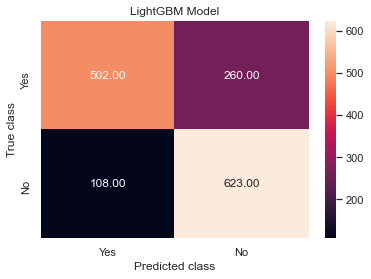

In [172]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

print('LGBM accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)), '\n')
print(classification_report(y_test, y_pred))

cm = metrics.confusion_matrix( y_test,y_pred, [1,0])
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LightGBM Model')

Modele daha önce target orjinal dağılım üzerinden  ayırdığımız ve modelin hiç görmediği test datası ile modelin sonuçlarını tekrar değerlendirelim. 

In [173]:
validation = pd.concat([valid_x,valid_y], axis=1)  

0   0.886
1   0.114
Name: y, dtype: float64


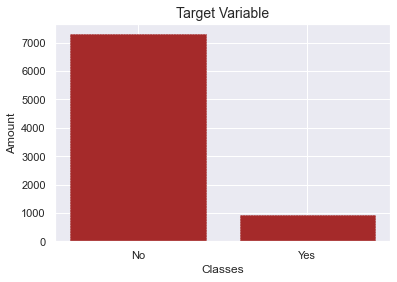

In [174]:
print((validation.y.value_counts()/validation.y.count()))

plt.bar(['No', 'Yes'], validation.y.value_counts().values, facecolor = 'brown', edgecolor='brown', linewidth=0.5, ls='dashed')
sns.set(font_scale=1)
plt.title('Target Variable', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

In [175]:
X_test = valid_x
y_test = valid_y

LGBM accuracy: 0.821 

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      7300
           1       0.35      0.64      0.45       937

    accuracy                           0.82      8237
   macro avg       0.65      0.74      0.67      8237
weighted avg       0.88      0.82      0.84      8237



Text(0.5, 1.0, 'LightGBM Model')

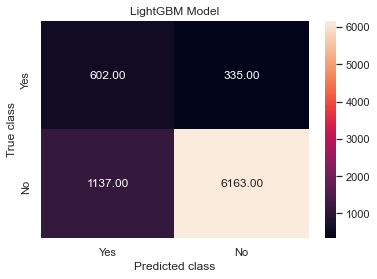

In [176]:
y_pred = lgbm.predict(X_test)

print('LGBM accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)), '\n')
print(classification_report(y_test, y_pred))

cm = metrics.confusion_matrix( y_test,y_pred, [1,0])
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LightGBM Model')

# CUMULATIVE GAIN & LIFT CHART

In [141]:
import scikitplot as skplt
ypred_prob=lgbm.predict_proba(X_test)

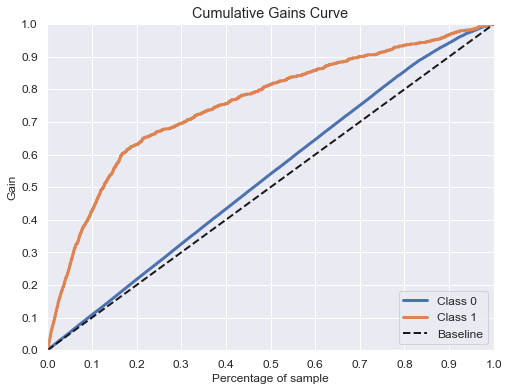

In [142]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, ypred_prob,figsize=(8, 6))
valueX = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
plt.xticks(valueX)
plt.yticks(valueX)
plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

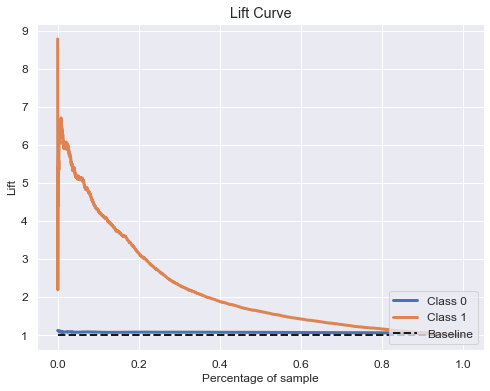

In [143]:
skplt.metrics.plot_lift_curve(y_test, ypred_prob,figsize=(8, 6))

# Oversampling - Smote

In [206]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE

In [207]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 101, sampling_strategy=0.7)

In [208]:
df.head()

,age,marital,education,housing,loan,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y,pdays_missing
0,1.200,married,basic.4y,no,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
1,1.267,married,high.school,no,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
2,-0.067,married,high.school,yes,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
3,0.133,married,basic.6y,no,no,-0.500,0,nonexistent,93.994,0.857,0.000,0,999
4,1.200,married,high.school,no,yes,-0.500,0,nonexistent,93.994,0.857,0.000,0,999


In [209]:
cat_attributes = df.select_dtypes(include=['category'])

In [210]:
cat_attributes.columns

Index(['marital', 'education', 'housing', 'loan', 'poutcome', 'pdays_missing'], dtype='object')

In [211]:
from SomeFunctions import one_hot_encoder
df, new_cols_ohe= one_hot_encoder(df, cat_attributes.columns, nan_as_category=True)
new_cols_ohe
len(new_cols_ohe)

25

In [212]:
cols = df.columns.difference(["y"])

In [213]:
# Resampling sonrası eğittiğimiz modelin target değişkenimizdeki orjinal dağılımına göre sonuçlarını görmek için,
# veri setimizi split ediyoruz. 

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold

folds = RepeatedKFold(n_splits= 5, n_repeats=10, random_state=1001)
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[cols], 
                                                            df['y'])):
    train_x, train_y = df[cols].iloc[train_idx], df['y'].iloc[train_idx]
    valid_x, valid_y = df[cols].iloc[valid_idx], df['y'].iloc[valid_idx]
    

In [214]:
over_X, overs_Y = sm.fit_resample(train_x, train_y)
over_train = pd.concat([pd.DataFrame(overs_Y), pd.DataFrame(over_X)], axis=1)

In [215]:
over_train.head()

,y,age,campaign,cons.conf.idx,cons.price.idx,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_nan,education_professional.course,education_university.degree,education_unknown,euribor3m,housing_nan,housing_unknown,housing_yes,loan_nan,loan_unknown,loan_yes,marital_married,marital_nan,marital_single,marital_unknown,pdays_missing_15+,pdays_missing_5-15,pdays_missing_999,pdays_missing_nan,poutcome_nan,poutcome_nonexistent,poutcome_success,previous
0,0,1.200,-0.500,0.857,93.994,0,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,0,1.267,-0.500,0.857,93.994,0,0,1,0,0,0,0,0,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,0,-0.067,-0.500,0.857,93.994,0,0,1,0,0,0,0,0,0.000,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
3,0,0.133,-0.500,0.857,93.994,1,0,0,0,0,0,0,0,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
4,0,1.200,-0.500,0.857,93.994,0,0,1,0,0,0,0,0,0.000,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0


LGBM accuracy: 0.912 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      5878
           1       0.92      0.86      0.89      4067

    accuracy                           0.91      9945
   macro avg       0.91      0.90      0.91      9945
weighted avg       0.91      0.91      0.91      9945



Text(0.5, 1.0, 'LightGBM Model')

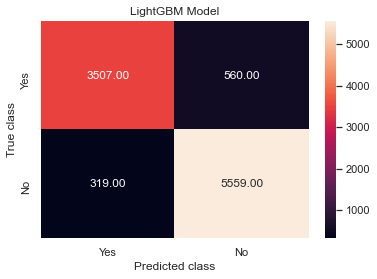

In [216]:
X = over_X
y = overs_Y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123456)

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

print('LGBM accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)), '\n')
print(classification_report(y_test, y_pred))

cm = metrics.confusion_matrix( y_test,y_pred, [1,0])
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LightGBM Model')

In [217]:
X_test = valid_x
y_test = valid_y

LGBM accuracy: 0.888 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7300
           1       0.51      0.43      0.46       937

    accuracy                           0.89      8237
   macro avg       0.72      0.69      0.70      8237
weighted avg       0.88      0.89      0.88      8237



Text(0.5, 1.0, 'LightGBM Model')

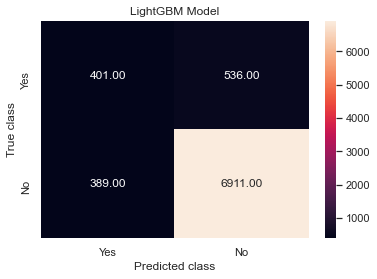

In [218]:
y_pred = lgbm.predict(X_test)

print('LGBM accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)), '\n')
print(classification_report(y_test, y_pred))

cm = metrics.confusion_matrix( y_test,y_pred, [1,0])
sns.heatmap(cm, annot=True, fmt='.2f',xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LightGBM Model')

# CUMULATIVE GAIN & LIFT CHART

In [219]:
import scikitplot as skplt
ypred_prob=lgbm.predict_proba(X_test)

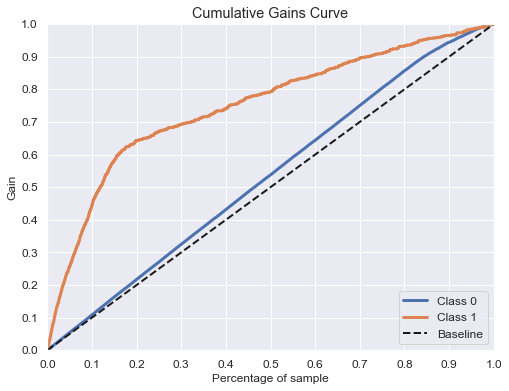

In [220]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, ypred_prob,figsize=(8, 6))
valueX = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0] 
plt.xticks(valueX)
plt.yticks(valueX)
plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

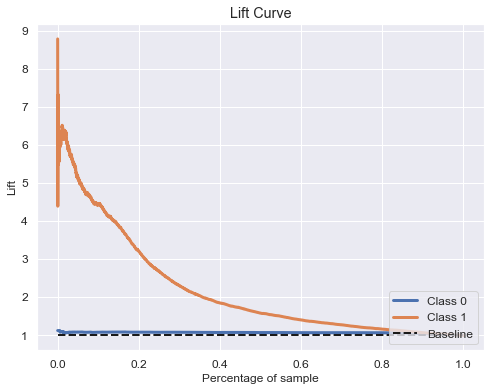

In [221]:
skplt.metrics.plot_lift_curve(y_test, ypred_prob,figsize=(8, 6))